In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install fanalysis
from fanalysis.mca import MCA

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [41]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [42]:
colonnes_montant = ["DEDUPLI", "IDENT", "SommeDeMONTANT_NUM", "Flag_Top_Montant", "NovosScore_Vingtile"]

data_montant_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/DONS_FDF_N_TODAY_1ers_gestes_REF_MD.txt", sep=";", header = 0, low_memory=False, dtype=str) #, dtype=str )#, dtype='Int64')

data_montant_orig.iloc[:,2]=data_montant_orig.iloc[:,2].str.replace(",",".")

data_montant_orig.columns =colonnes_montant
data_montant_orig["SommeDeMONTANT_NUM"]=data_montant_orig["SommeDeMONTANT_NUM"].astype(float)

In [43]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_8_new_my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, dtype=str )#, dtype='Int64')


In [44]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1192180, 23)

In [45]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,0010000001,02,81,08,91,09,06,21,21,01,71,41,07,04,12,04,20,02,02,01,51,05,1
1,0010000006,01,75,07,43,04,06,06,13,02,71,64,07,06,12,09,04,12,04,13,12,01,1
2,0010000011,01,76,07,43,04,06,06,16,03,54,81,05,08,07,12,06,06,04,18,36,03,2
3,0010000013,03,75,07,43,04,04,06,13,01,71,36,07,03,12,11,11,19,04,06,21,02,1
4,0010000015,02,33,03,44,04,06,07,12,01,71,42,07,04,12,05,14,03,03,01,14,01,2


In [46]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    colonnes = tableau_corr.columns
    val_temp = 0 
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
                val_temp += 1

            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
                val_temp += 1
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0
    if val_temp == 0:
        print("IL N'Y A PAS DE CORRELATION ENTRE LES VARIABLES PAR RAPPORT AU SEUIL PRIS")
        

def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train)))  
    print(classification_report(y_train, model.predict(X_train) ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def vingtiles(model, data_orig, affichage, save, path): # data_orig est une variables locale (peut être différente au df d'origine)
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe Top_mon)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # vingtiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    #print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)

    # création de la dernière colonne CLASSE et son remplissage
    index_20_ord = pd.DataFrame(np.unique(df_tous["TRANCHES"])) 
    df_tous["CLASSE"]=df_tous["TRANCHES"].copy()
    ind_val=1
    for kk in range(20):
        df_tous["CLASSE"][df_tous["CLASSE"]== index_20_ord.iloc[kk,0] ] = str(ind_val) 
        ind_val+=1
    print(df_tous)    
    
    # pour la colonne Top_mon : changement de type de variable et remplissage des valeurs (s'il le faut)
    data_temp_t = data_orig.copy()
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t #data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne TOTAL
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

    return  df_tous


def tableau_5_montant(df_tous, data_montant_orig, affichage, save, path):
    # tableau avec les deux variables qui nous intéressent
    ident_et_montant = data_montant_orig[["IDENT","SommeDeMONTANT_NUM"]]

    # jointure
    tableau_resultats_et_montant = pd.merge(df_tous,ident_et_montant)
    #print(tableau_resultats_et_montant) 

    # on élimine toutes les sommes supérieur à 5000 €
    tableau_resultats_et_montant = tableau_resultats_et_montant[tableau_resultats_et_montant["SommeDeMONTANT_NUM"] <= 5000]
    print(tableau_resultats_et_montant) 
    #print(tableau_resultats_et_montant["TRANCHES"].value_counts())
    #print(pd.DataFrame(np.unique(tableau_resultats_et_montant["TRANCHES"])))

    # index
    index_temp = pd.DataFrame(np.unique(tableau_resultats_et_montant["TRANCHES"])) 

    # création du tableau qui contiendra les résultats finaux
    tableau_resultats_finaux = pd.DataFrame(columns=["TRANCHES","Moyen_Somme","TOTAL"],index=range(20))
    tableau_resultats_finaux["TRANCHES"] = index_temp

    # remplissage du tableau final
    for k in range(20):
        tableau_resultats_finaux.iloc[k,1] = tableau_resultats_et_montant[tableau_resultats_et_montant["TRANCHES"]==index_temp.iloc[k,0]]["SommeDeMONTANT_NUM"].mean()
        tableau_resultats_finaux.iloc[k,2] = (tableau_resultats_et_montant["TRANCHES"]==index_temp.iloc[k,0]).sum()
    
    # affichage
    if affichage:        
        print(tableau_resultats_finaux)
    
    # enregistrement sous Excel
    if save:
        tableau_resultats_finaux.to_excel(path)


def vingtiles_ind_sans_target(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    print(df_tous)
    print(df_tous["TRANCHES"].value_counts(ascending = True))

    # GERE L'ORDRE
    patra = np.unique(df_tous.iloc[:,2], return_counts=True)
    df_tranches_sans_target = pd.DataFrame([patra[0],patra[1]]).T
    df_tranches_sans_target.columns=["TRANCHES","COUNTS"]

    # affichage
    if affichage ==True:        
        print(df_tranches_sans_target)
    
    # enregistrement sous Excel
    if save == True:
        df_tranches_sans_target.to_excel(path)
    

# élimination des variables trop corrélées (choix manuel)
def elimination_val_corr(data):
    data = data.drop(columns=[""])
    return data
          
 

In [47]:
nombre_mod(data)

,VARIABLE,NOMBRE_MOD,NOMBRE_MOD_SANS_NA
0,IDENT,1191464,1191464
1,TypeHabi,4,4
2,GeoFaz_Scl,38,38
3,GeoFaz_cl,8,8
4,ImmoFaz_Scl,31,31
5,ImmoFaz_cl,9,9
6,Anciennete,11,11
7,Logement_prix_m2,21,21
8,Mediane_RFR,21,21
9,Sexe,5,5


In [48]:
data["Top_mon"].value_counts(dropna=False)

NaN    1092884
2        72568
1        26728
Name: Top_mon, dtype: int64

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192180 entries, 0 to 1192179
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1192180 non-null  object
 1   TypeHabi            1192180 non-null  object
 2   GeoFaz_Scl          1192180 non-null  object
 3   GeoFaz_cl           1192180 non-null  object
 4   ImmoFaz_Scl         1192180 non-null  object
 5   ImmoFaz_cl          1192180 non-null  object
 6   Anciennete          1192180 non-null  object
 7   Logement_prix_m2    1192180 non-null  object
 8   Mediane_RFR         1192180 non-null  object
 9   Sexe                1192180 non-null  object
 10  Prenom_Phase_scl_H  1192180 non-null  object
 11  Prenom_Phase_scl_F  1192180 non-null  object
 12  Prenom_Phase_cl_H   1192180 non-null  object
 13  Prenom_Phase_cl_F   1192180 non-null  object
 14  Age_H               1192180 non-null  object
 15  Age_F               1192180 non-

In [50]:
############################################################### AJOUTER OU EFFACER (data =) #######################################
# on élimine les variables corr
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)


In [51]:
num_var_max = data.shape[1] - 1
num_var_max

15

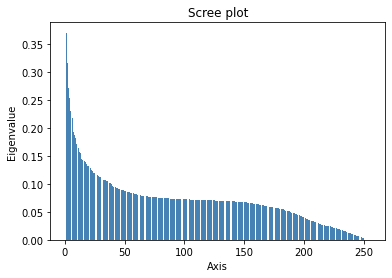

None


In [52]:
#importation de la librairie
from fanalysis.mca import MCA

#instanciation
acm = MCA(var_labels=data.columns[1:num_var_max])

# apprentissage
dim_temporaire = data_orig[(data_orig.isnull()).sum(axis=1) == 0].shape[0]
acm.fit(data.iloc[:dim_temporaire,1:num_var_max].values)

#valeurs propres - graphique
print(acm.plot_eigenvalues())

In [53]:
# fonction qui va diviser et calculer les coordonnées des individus 
def transform_to_coord(data):
    coord_part = 0
    coord = acm.transform(data.iloc[0:30000,1:num_var_max].values)
    k=30000
    nb_part = round(data.shape[0]/k)
    for i in range(1, nb_part):
        coord_part=acm.transform(data.iloc[i*k:(i+1)*k,1:num_var_max].values)
        coord=np.concatenate((coord, coord_part))

    coord_part = acm.transform(data.iloc[nb_part*k: ,1:num_var_max].values )
    coord=np.concatenate((coord, coord_part))
    return coord

In [54]:
#instanciation
acm = MCA(var_labels = data.columns[1:num_var_max], n_components=55)  # paramètres index manquante (gérer après)
#apprentissage 
"ne pas utiliser fit_tranform car le datset est trop grand "
dim_temporaire = data_orig[(data_orig.isnull()).sum(axis=1) == 0].shape[0]
acm.fit(data.iloc[:dim_temporaire,1:num_var_max].values)

# tranformation du dataset
coord = transform_to_coord(data)


In [55]:
# dimension
coord.shape

(1192180, 55)

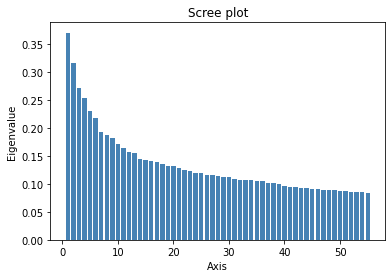

None


In [56]:
#valeurs propres - graphique
print(acm.plot_eigenvalues())


In [57]:
#coordonnées des colonnes
print(acm.col_topandas())

                     col_coord_dim1  col_coord_dim2  col_coord_dim3  \
TypeHabi_01                0.332183       -0.202362       -0.231645   
TypeHabi_02               -0.145991        0.076641        0.096391   
TypeHabi_03                0.130764       -0.006427       -0.049888   
TypeHabi_04                0.106165       -0.912794       -2.005275   
GeoFaz_Scl_11             -0.127093       -0.005029       -0.083136   
...                             ...             ...             ...   
Potentiel_prenom_17       -1.300294        0.054908        0.854744   
Potentiel_prenom_18       -1.162968        0.042447        0.258765   
Potentiel_prenom_19       -1.255502        0.014836       -0.832904   
Potentiel_prenom_20       -1.149292        0.022841       -1.259650   
Potentiel_prenom_21        0.298405       -5.820721        0.498699   

                     col_coord_dim4  col_coord_dim5  col_coord_dim6  \
TypeHabi_01                0.242887       -0.173721        0.234663   
TypeH

In [58]:
#nombre var. actives
p = data.shape[1]-1
print(p)
#calcul des fonctions de projection
fproj = np.zeros(acm.col_coord_.shape)
#pour chaque colonne
for j in range(fproj.shape[1]):
 fproj[:,j] = acm.col_coord_[:,j]/(p*np.sqrt(acm.eig_[0,j]))
#affichage fonction
print(fproj)
#affichage plus avenant des deux premiers facteurs
print(pd.DataFrame(fproj,index=acm.col_labels_))


15
[[ 0.0363745  -0.02395679 -0.02967096 ...  0.00912592 -0.01789951
  -0.01407735]
 [-0.01598628  0.00907323  0.01234655 ...  0.00424292 -0.01686645
  -0.01058414]
 [ 0.01431884 -0.0007609  -0.00639004 ... -0.04064256  0.12966795
   0.08903856]
 ...
 [-0.13747924  0.00175632 -0.10668513 ... -0.04029207  0.06918552
  -0.04230643]
 [-0.12584915  0.0027041  -0.16134627 ...  0.059268   -0.05555159
   0.0481111 ]
 [ 0.03267582 -0.68909142  0.06387752 ... -0.01522862  0.01507019
   0.0075577 ]]
                           0         1         2         3         4   \
TypeHabi_01          0.036374 -0.023957 -0.029671  0.032196 -0.024136   
TypeHabi_02         -0.015986  0.009073  0.012347 -0.012376  0.009787   
TypeHabi_03          0.014319 -0.000761 -0.006390  0.003051 -0.003473   
TypeHabi_04          0.011625 -0.108062 -0.256852 -0.029606 -0.261229   
GeoFaz_Scl_11       -0.013917 -0.000595 -0.010649  0.008189  0.014256   
...                       ...       ...       ...       ...       .

In [59]:
# affichafe des 10 premières lignes
print(coord[:2,:])


[[ 9.01913285e-01 -2.09883556e-01 -1.58151918e+00  3.39904799e-01
  -1.55754346e+00  1.98470948e-01  4.60805222e+00  5.26594712e-01
  -2.89404151e-01  1.01153160e-01  3.48560994e-01  4.52024071e-01
   9.88762191e-02 -8.05669197e-01 -5.06490177e-01 -1.17963205e+00
   3.32491077e-01  6.04743324e-01 -7.89071534e-02  3.31673468e-01
   6.98336905e-01  1.52708935e-01  2.09341648e-01 -2.35928946e-02
  -2.93807952e-01 -4.76460395e-01 -5.17969126e-01  1.68319325e-01
   3.20740801e-01  1.22734109e+00  4.37396808e-01  1.32535955e+00
  -1.00692914e+00 -5.29530068e-01 -8.94754337e-02 -1.62054881e+00
  -5.34084124e-01 -2.80052959e-01 -1.11643911e+00 -1.13165105e+00
   6.85239367e-01 -7.74801379e-01 -1.28496486e+00 -1.09831885e+00
   1.27227786e+00  2.98839543e-01  3.25815776e-01  6.70631414e-01
   7.14424154e-01  4.13236106e-01 -1.89596586e-01 -3.54905304e-02
   2.04203685e-01 -8.43234963e-02  9.70357416e-02]
 [ 6.01636503e-01  7.30355812e-02 -1.12990965e-01  1.47301668e-01
   5.59992208e-01  4.8722

In [60]:
#print(data_sans_nan.shape)
#print(coord_sans_nan.shape)
#print(data_sans_nan.iloc[:,0])
#dfff.isnull().sum(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192180 entries, 0 to 1192179
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1192180 non-null  object
 1   TypeHabi            1192180 non-null  object
 2   GeoFaz_Scl          1192180 non-null  object
 3   Anciennete          1192180 non-null  object
 4   Logement_prix_m2    1192180 non-null  object
 5   Mediane_RFR         1192180 non-null  object
 6   Sexe                1192180 non-null  object
 7   Prenom_Phase_scl_H  1192180 non-null  object
 8   Prenom_Phase_scl_F  1192180 non-null  object
 9   Age_H               1192180 non-null  object
 10  Age_F               1192180 non-null  object
 11  Affinite_1          1192180 non-null  object
 12  Affinite_2          1192180 non-null  object
 13  Prenom_effectif     1192180 non-null  object
 14  Potentiel_prenom    1192180 non-null  object
 15  Top_mon             99296 non-nu

In [61]:
## ATTENTION
# élimination des individus n'ayant pas de valeur pour la variable Top_mon
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]
coord_sans_nan = coord[(data.isnull()).sum(axis=1) == 0] # coordonnées

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int) # essayer avec int64

# création
def creation_df_temp(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1] ): #avant 10
        dfff[str(i)]=coord_sans_nan[:,i]
    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1].astype(int)
    return dfff
# stockage
data_coord_nan = creation_df_temp(data_sans_nan, coord_sans_nan)
data_coord_nan.info()
#data_coord_nan = dfff 

# maintien des individus  n'ayant pas de valeur pour la variable Top_mon

data_avec_nan = data
coord_avec_nan = coord # coordonnées
def creation_df_temp_2(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1]): # avant 10
        dfff[str(i)]=coord_sans_nan[:,i]

    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1] #.astype(int)

    dfff["Top_mon"] = dfff["Top_mon"].replace(1.0, '1')
    dfff["Top_mon"] = dfff["Top_mon"].replace(2.0,'2')
    #for j in range(data_sans_nan.shape[1]):
    #    if dfff.iloc[j,10+1] == 2.0:
    #        dfff.iloc[j,10+1] = 2
    #    if dfff.iloc[j, 10+1] ==1.0:
    #        dfff.iloc[j,10+1] =1

    return dfff
data_coord_avec_nan = creation_df_temp_2(data_avec_nan, coord_avec_nan)
data_coord_avec_nan.info()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99296 entries, 0 to 99295
Data columns (total 57 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   IDENT    99296 non-null  object 
 1   0        99296 non-null  float64
 2   1        99296 non-null  float64
 3   2        99296 non-null  float64
 4   3        99296 non-null  float64
 5   4        99296 non-null  float64
 6   5        99296 non-null  float64
 7   6        99296 non-null  float64
 8   7        99296 non-null  float64
 9   8        99296 non-null  float64
 10  9        99296 non-null  float64
 11  10       99296 non-null  float64
 12  11       99296 non-null  float64
 13  12       99296 non-null  float64
 14  13       99296 non-null  float64
 15  14       99296 non-null  float64
 16  15       99296 non-null  float64
 17  16       99296 non-null  float64
 18  17       99296 non-null  float64
 19  18       99296 non-null  float64
 20  19       99296 non-null  float64
 21  20       992

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

import imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE


In [63]:
#data_coord_nan.shape
#train_X_s.shape

In [64]:
#data_non_corr = elimination_val_corr(data)
#nb_var = data_non_corr.shape[1] - 1
nb_var = data_coord_nan.shape[1] - 1

train_set, test_set = train_test_split(data_coord_nan, test_size = 0.2, random_state=0) # , stratify =data_coord_nan["IFI+"] )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

# comme les résulats sont en overfitting :
# Résultat du traitement sur le train set (under-sampling et over-sampling)
#abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_val_corr_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
#abc_np = abc_test.to_numpy(dtype="Int64")

#X_resampled = abc_np[:,:-1]
#y_resampled = abc_np[:, abc_np.shape[1] -1 ]


In [65]:

# dimension du train set
print("Sans aucun traitement sur le train set : " , np.unique(train_Y_s, return_counts=True))

# diminution des données
t2 = TomekLinks(random_state=0)
X_resampled, y_resampled = t2.fit_resample(train_X_s[:,:nb_var] , train_Y_s )
print("Après under-sampling : ", np.unique(y_resampled, return_counts=True ))

# augmentation des données
tl = SMOTE(random_state=0)
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled )
print("Après over-smapling : " , np.unique(y_resampled, return_counts=True ))

'''
# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps 
pd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),
                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",
                                            sep=" ", index =False , header = False )
'''

Sans aucun traitement sur le train set :  (array([1, 2]), array([21397, 58039]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Après under-sampling :  (array([1, 2]), array([21397, 51054]))
Après over-smapling :  (array([1, 2]), array([51054, 51054]))


'\n# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps \npd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),\n                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",\n                                            sep=" ", index =False , header = False )\n'

In [66]:
model_LinearDiscriminantAnalysis = LinearDiscriminantAnalysis()
param = {"solver" : ["svd","lsqr", "eigen"], "tol" : [0.00001,0.0001,0.001,0.01]}

grid_LinearDiscriminantAnalysis = GridSearchCV(model_LinearDiscriminantAnalysis, param_grid= param, cv = 4, scoring = "f1")
resultat_grid_LinearDiscriminantAnalysis = grid_LinearDiscriminantAnalysis.fit(X_resampled, y_resampled)
resultat_grid_LinearDiscriminantAnalysis.best_params_ 

{'solver': 'svd', 'tol': 1e-05}

In [67]:
final_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(final_model_ADL, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "recall", plot=False)

test set : 
[[3183 2148]
 [5950 8579]]
              precision    recall  f1-score   support

           1       0.35      0.60      0.44      5331
           2       0.80      0.59      0.68     14529

    accuracy                           0.59     19860
   macro avg       0.57      0.59      0.56     19860
weighted avg       0.68      0.59      0.62     19860

train set : 
[[30219 20835]
 [19855 31199]]
              precision    recall  f1-score   support

           1       0.60      0.59      0.60     51054
           2       0.60      0.61      0.61     51054

    accuracy                           0.60    102108
   macro avg       0.60      0.60      0.60    102108
weighted avg       0.60      0.60      0.60    102108

GRAPHIQUE NON DEMANDE


In [68]:
#classe pour l'analyse discriminante

#instanciation
adl = LinearDiscriminantAnalysis()
#apprentissage
adl.fit(coord_sans_nan,data_sans_nan["Top_mon"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [69]:
#reconstitution de la fonction sur indicatrices (multiplication)
fpValues = np.dot(fproj,np.transpose(adl.coef_))
#print(fpValues)
#affichage plus joli
pd.DataFrame(fpValues,index=acm.col_labels_)

,0
TypeHabi_01,-0.093445
TypeHabi_02,0.038804
TypeHabi_03,-0.021734
TypeHabi_04,-0.455233
GeoFaz_Scl_11,-0.049130
...,...
Potentiel_prenom_17,-0.028254
Potentiel_prenom_18,-0.081114
Potentiel_prenom_19,-0.077301
Potentiel_prenom_20,-0.140148


In [70]:
# TRAIN SET TEST SET
vingtiles_tableau = vingtiles(model = final_model_ADL, data_orig = data_coord_nan, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ACM_ADL_55.xlsx")

            IDENT     PROBA
73678  0010408023  0.114864
11693  0010258609  0.116910
85390  0010519316  0.119418
8403   0010255206  0.131544
21974  0010338341  0.141150
...           ...       ...
51004  0010376561  0.873636
12520  0010259455  0.873636
75590  0010410331  0.873636
88332  0010524378  0.894030
76474  0010411847  0.896718

[99296 rows x 2 columns]
0.833813    49
0.804308    28
0.638842    24
0.825461    19
0.771718    19
            ..
0.727852     1
0.374694     1
0.569101     1
0.777392     1
0.660762     1
Name: PROBA, Length: 96552, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


            IDENT     PROBA        TRANCHES CLASSE
73678  0010408023  0.114864   (0.114, 0.29]      1
11693  0010258609  0.116910   (0.114, 0.29]      1
85390  0010519316  0.119418   (0.114, 0.29]      1
8403   0010255206  0.131544   (0.114, 0.29]      1
21974  0010338341  0.141150   (0.114, 0.29]      1
...           ...       ...             ...    ...
51004  0010376561  0.873636  (0.697, 0.897]     20
12520  0010259455  0.873636  (0.697, 0.897]     20
75590  0010410331  0.873636  (0.697, 0.897]     20
88332  0010524378  0.894030  (0.697, 0.897]     20
76474  0010411847  0.896718  (0.697, 0.897]     20

[99296 rows x 4 columns]
Top_mon            1     2  TOTAL
TRANCHES                         
(0.114, 0.29]    683  4282   4965
(0.29, 0.328]    823  4142   4965
(0.328, 0.355]   874  4091   4965
(0.355, 0.378]   885  4080   4965
(0.378, 0.399]   995  3969   4964
(0.399, 0.417]  1033  3932   4965
(0.417, 0.435]  1070  3895   4965
(0.435, 0.452]  1054  3911   4965
(0.452, 0.469]  1226  

In [71]:
# TABLEAU MONTANT
tableau_5_montant(vingtiles_tableau, data_montant_orig, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/montant_ACM_ADL_55.xlsx")

            IDENT     PROBA        TRANCHES CLASSE  SommeDeMONTANT_NUM
0      0010408023  0.114864   (0.114, 0.29]      1                20.0
1      0010258609  0.116910   (0.114, 0.29]      1                20.0
2      0010519316  0.119418   (0.114, 0.29]      1                20.0
3      0010255206  0.131544   (0.114, 0.29]      1                15.0
4      0010338341  0.141150   (0.114, 0.29]      1                20.0
...           ...       ...             ...    ...                 ...
99291  0010376561  0.873636  (0.697, 0.897]     20               500.0
99292  0010259455  0.873636  (0.697, 0.897]     20                50.0
99293  0010410331  0.873636  (0.697, 0.897]     20                50.0
99294  0010524378  0.894030  (0.697, 0.897]     20                15.0
99295  0010411847  0.896718  (0.697, 0.897]     20                30.0

[99146 rows x 5 columns]
          TRANCHES Moyen_Somme TOTAL
0    (0.114, 0.29]     27.9929  4964
1    (0.29, 0.328]     29.9027  4964
2   (0.328,

In [72]:
"""
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = final_model_ADL, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ACM_ADL_15.xlsx")
"""

'\n# INDIVIDUS SANS TARGET\nvingtiles_ind_sans_target(model = final_model_ADL, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,\n            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ACM_ADL_15.xlsx")\n'

In [73]:
model_ADQ = QuadraticDiscriminantAnalysis()
evaluation(model_ADQ, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1", plot=False)


test set : 
[[2864 2467]
 [5289 9240]]
              precision    recall  f1-score   support

           1       0.35      0.54      0.42      5331
           2       0.79      0.64      0.70     14529

    accuracy                           0.61     19860
   macro avg       0.57      0.59      0.56     19860
weighted avg       0.67      0.61      0.63     19860

train set : 
[[27584 23470]
 [17700 33354]]
              precision    recall  f1-score   support

           1       0.61      0.54      0.57     51054
           2       0.59      0.65      0.62     51054

    accuracy                           0.60    102108
   macro avg       0.60      0.60      0.60    102108
weighted avg       0.60      0.60      0.60    102108

GRAPHIQUE NON DEMANDE


In [74]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles_tableau = vingtiles(model =model_ADQ, data_orig = data_coord_nan, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ACM_ADQ_55.xlsx")

            IDENT          PROBA
39841  0010364732   0.000000e+00
16041  0010263606   0.000000e+00
96630  0010536346  3.927216e-207
36200  0010360794  5.552899e-177
94441  0010532578  6.611069e-177
...           ...            ...
83713  0010504904   1.000000e+00
83722  0010504930   1.000000e+00
83737  0010505025   1.000000e+00
83404  0010503481   1.000000e+00
0      0010000001   1.000000e+00

[99296 rows x 2 columns]
1.000000    316
1.000000     49
1.000000     28
0.996478     24
1.000000     19
           ... 
0.651542      1
0.848683      1
0.252042      1
0.899238      1
0.999971      1
Name: PROBA, Length: 96254, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


            IDENT          PROBA              TRANCHES CLASSE
39841  0010364732   0.000000e+00  (-1e-05, 2.2219e-05]      1
16041  0010263606   0.000000e+00  (-1e-05, 2.2219e-05]      1
96630  0010536346  3.927216e-207  (-1e-05, 2.2219e-05]      1
36200  0010360794  5.552899e-177  (-1e-05, 2.2219e-05]      1
94441  0010532578  6.611069e-177  (-1e-05, 2.2219e-05]      1
...           ...            ...                   ...    ...
83713  0010504904   1.000000e+00        (0.99995, 1.0]     20
83722  0010504930   1.000000e+00        (0.99995, 1.0]     20
83737  0010505025   1.000000e+00        (0.99995, 1.0]     20
83404  0010503481   1.000000e+00        (0.99995, 1.0]     20
0      0010000001   1.000000e+00        (0.99995, 1.0]     20

[99296 rows x 4 columns]
Top_mon                      1     2  TOTAL
TRANCHES                                   
(-1e-05, 2.2219e-05]       844  4121   4965
(2.2219e-05, 0.00068522]   867  4098   4965
(0.00068522, 0.0039006]    906  4059   4965
(0.0039006

In [75]:
# TABLEAU MONTANT
tableau_5_montant(vingtiles_tableau, data_montant_orig, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/montant_ACM_ADQ_55.xlsx")

            IDENT          PROBA              TRANCHES CLASSE  \
0      0010364732   0.000000e+00  (-1e-05, 2.2219e-05]      1   
1      0010263606   0.000000e+00  (-1e-05, 2.2219e-05]      1   
2      0010536346  3.927216e-207  (-1e-05, 2.2219e-05]      1   
3      0010360794  5.552899e-177  (-1e-05, 2.2219e-05]      1   
4      0010532578  6.611069e-177  (-1e-05, 2.2219e-05]      1   
...           ...            ...                   ...    ...   
99291  0010504904   1.000000e+00        (0.99995, 1.0]     20   
99292  0010504930   1.000000e+00        (0.99995, 1.0]     20   
99293  0010505025   1.000000e+00        (0.99995, 1.0]     20   
99294  0010503481   1.000000e+00        (0.99995, 1.0]     20   
99295  0010000001   1.000000e+00        (0.99995, 1.0]     20   

       SommeDeMONTANT_NUM  
0                  1750.0  
1                    15.0  
2                     5.0  
3                    30.0  
4                    30.0  
...                   ...  
99291                50

In [76]:
"""
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = model_ADQ, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ACM_ADQ_15.xlsx")
"""

'\n# INDIVIDUS SANS TARGET\nvingtiles_ind_sans_target(model = model_ADQ, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,\n            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ACM_ADQ_15.xlsx")\n'

In [ ]:
###############################################################################
###############################################################################

In [ ]:
# SANS UNDER-SAMPLING ET OVER-SAMPLING

print("ADL test sans under-sampling et over_sampling")
test_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADL, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

print("ADQ test sans under-sampling et over_sampling")
test_model_ADQ = QuadraticDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADQ, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

vingtiles(model =test_model_ADQ, data_orig = data_coord_nan, affichage=True,
          save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ADL.xlsx")


ADL test sans under-sampling et over_sampling
test set : 
[[  362  4969]
 [  304 14225]]
              precision    recall  f1-score   support

           1       0.54      0.07      0.12      5331
           2       0.74      0.98      0.84     14529

    accuracy                           0.73     19860
   macro avg       0.64      0.52      0.48     19860
weighted avg       0.69      0.73      0.65     19860

train set : 
[[ 1333 20064]
 [ 1059 56980]]
              precision    recall  f1-score   support

           1       0.56      0.06      0.11     21397
           2       0.74      0.98      0.84     58039

    accuracy                           0.73     79436
   macro avg       0.65      0.52      0.48     79436
weighted avg       0.69      0.73      0.65     79436

GRAPHIQUE NON DEMANDE
ADQ test sans under-sampling et over_sampling
test set : 
[[ 1034  4297]
 [ 1465 13064]]
              precision    recall  f1-score   support

           1       0.41      0.19      0.26    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


            IDENT     PROBA           TRANCHES CLASSE
29349  0010349327  0.002981  (0.00198, 0.0213]      1
71553  0010405567  0.003858  (0.00198, 0.0213]      1
15120  0010262361  0.004484  (0.00198, 0.0213]      1
31093  0010351666  0.004811  (0.00198, 0.0213]      1
50732  0010376221  0.005193  (0.00198, 0.0213]      1
...           ...       ...                ...    ...
15987  0010263545  1.000000       (0.964, 1.0]     20
29779  0010349936  1.000000       (0.964, 1.0]     20
6059   0010252767  1.000000       (0.964, 1.0]     20
56998  0010384509  1.000000       (0.964, 1.0]     20
0      0010000001  1.000000       (0.964, 1.0]     20

[99296 rows x 4 columns]
Top_mon               1     2  TOTAL
TRANCHES                            
(0.00198, 0.0213]   815  4150   4965
(0.0213, 0.0277]    911  4054   4965
(0.0277, 0.0387]    930  4035   4965
(0.0387, 0.0514]    947  4018   4965
(0.0514, 0.0612]    980  3984   4964
(0.0612, 0.0688]   1115  3850   4965
(0.0688, 0.0768]   1096  3869 

,IDENT,PROBA,TRANCHES,CLASSE
29349,0010349327,0.002981,"(0.00198, 0.0213]",1
71553,0010405567,0.003858,"(0.00198, 0.0213]",1
15120,0010262361,0.004484,"(0.00198, 0.0213]",1
31093,0010351666,0.004811,"(0.00198, 0.0213]",1
50732,0010376221,0.005193,"(0.00198, 0.0213]",1
...,...,...,...,...
15987,0010263545,1.000000,"(0.964, 1.0]",20
29779,0010349936,1.000000,"(0.964, 1.0]",20
6059,0010252767,1.000000,"(0.964, 1.0]",20
56998,0010384509,1.000000,"(0.964, 1.0]",20


In [ ]:
#################################################################################
#################################################################################

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from scipy.stats import shapiro

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

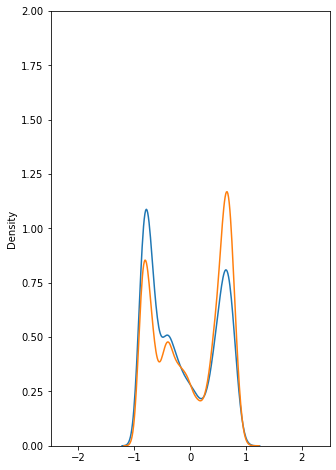

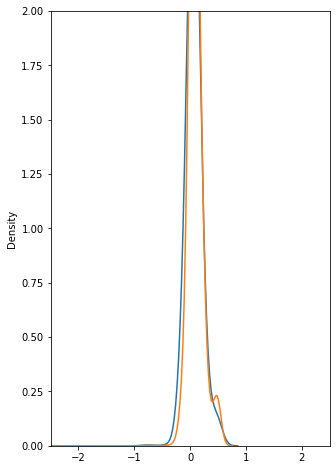

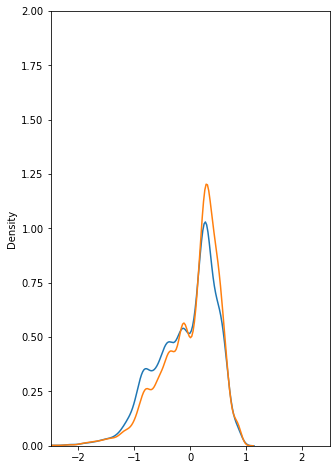

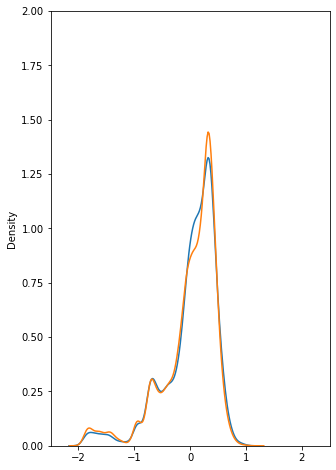

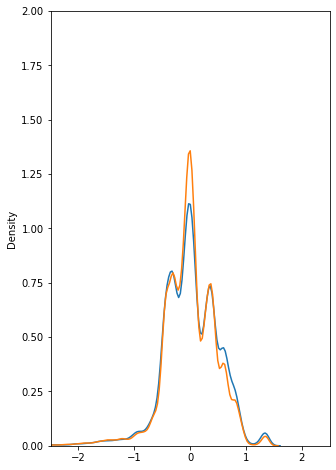

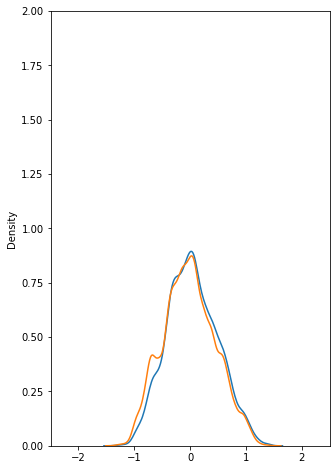

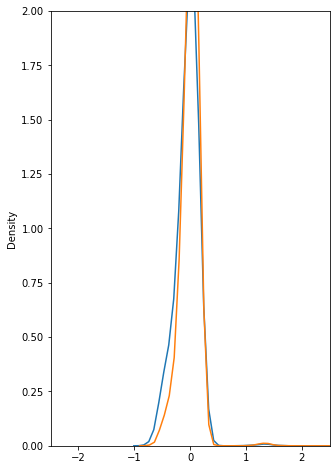

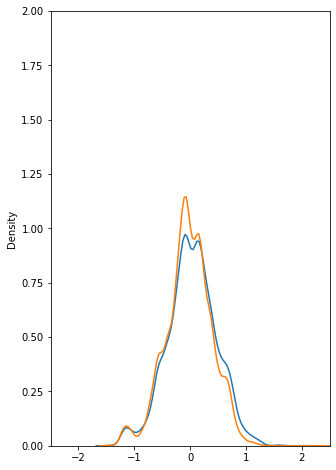

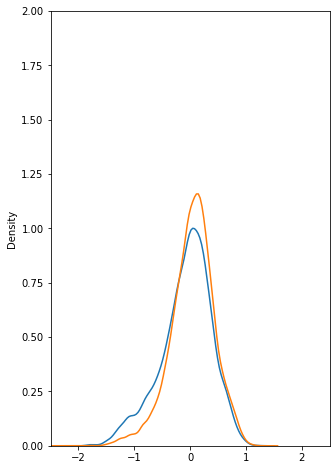

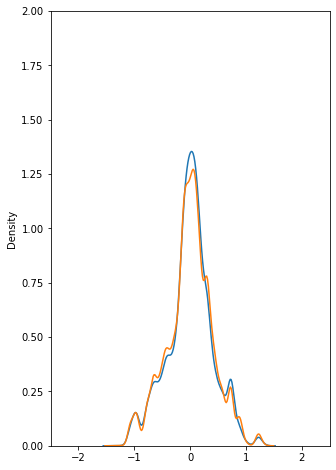

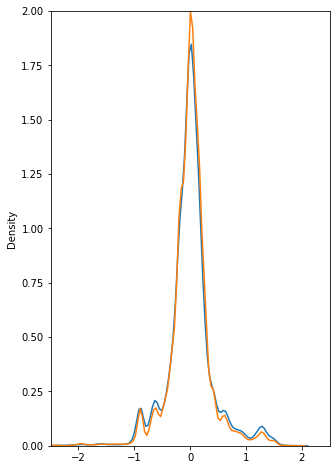

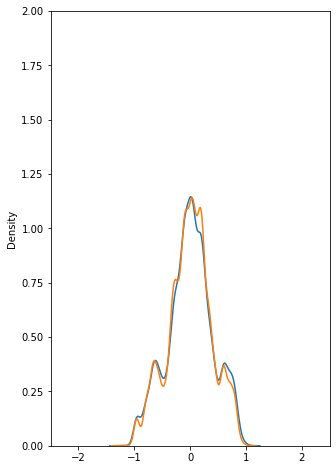

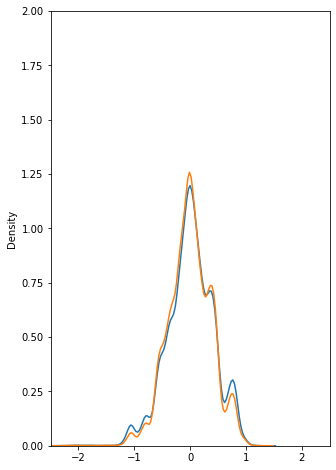

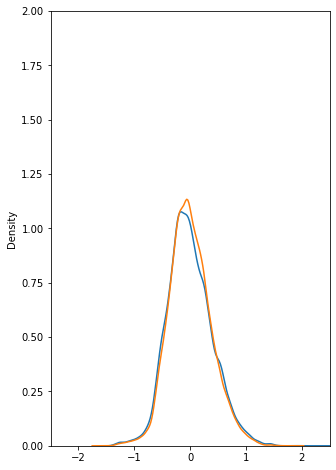

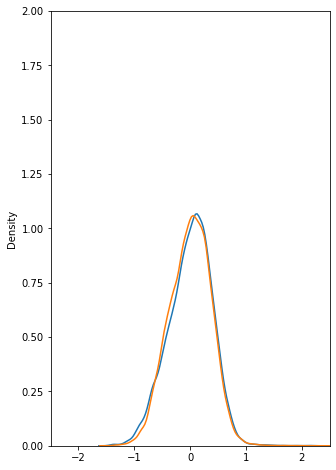

In [ ]:

for i in range(0,15):
    plt.figure(figsize=(5,8))
    sns.distplot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,i],hist=False) 
    sns.distplot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,i],hist=False) 
    plt.xlim((-2.5,2.5))
    plt.ylim((0,2))


In [ ]:
for j in range(15):
    print( shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==1,j]), shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==2,j]) )

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: 

(0.8889386653900146, 0.0) (0.88752681016922, 0.0)
(0.33572298288345337, 0.0) (0.3221573829650879, 0.0)
(0.9529616832733154, 0.0) (0.9291819334030151, 0.0)
(0.8717105388641357, 0.0) (0.861024022102356, 0.0)
(0.95638507604599, 0.0) (0.9423134922981262, 0.0)
(0.9959754347801208, 6.040618565258718e-26) (0.9951214790344238, 7.894775418159587e-41)
(0.2060166597366333, 0.0) (0.23741638660430908, 0.0)
(0.949048638343811, 0.0) (0.9674699902534485, 0.0)
(0.948469877243042, 0.0) (0.9614996314048767, 0.0)
(0.9854901432991028, 9.80908925027372e-45) (0.9900328516960144, 0.0)
(0.8798614144325256, 0.0) (0.8598746061325073, 0.0)
(0.9900939464569092, 1.3937046878167945e-38) (0.9910640716552734, 0.0)
(0.9853678941726685, 7.006492321624085e-45) (0.9859757423400879, 0.0)
(0.9913292527198792, 1.508155700654167e-36) (0.9938042163848877, 8.407790785948902e-45)
(0.9881532788276672, 2.094801074319169e-41) (0.9904729127883911, 0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: 

In [ ]:
shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==1,:]), shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==2,:])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


((0.8687389492988586, 0.0), (0.9115259051322937, 0.0))

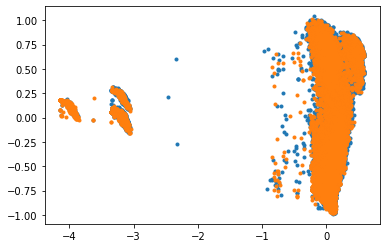

In [ ]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,1], coord_sans_nan[data_sans_nan.iloc[:,15]==2,0],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1], coord_sans_nan[data_sans_nan.iloc[:,15]==1,0],".")

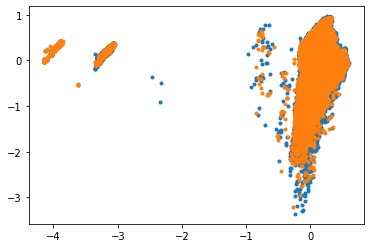

In [ ]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,1], coord_sans_nan[data_sans_nan.iloc[:,15]==2,2],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1], coord_sans_nan[data_sans_nan.iloc[:,15]==1,2],".")

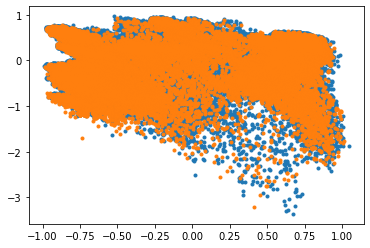

In [ ]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,0], coord_sans_nan[data_sans_nan.iloc[:,15]==2,2],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,0], coord_sans_nan[data_sans_nan.iloc[:,15]==1,2],".")

In [ ]:
for j in range(15):#23456
    hhh = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==2,j])
    
    q_low = hhh.quantile(0.05)
    q_hi  = hhh.quantile(0.95)
    df_filtered = hhh[(hhh < q_hi) & (hhh > q_low)]

    print(shapiro(df_filtered.dropna()))


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: 

(0.8826243877410889, 0.0)
(0.9888412356376648, 0.0)
(0.9318932294845581, 0.0)
(0.9116094708442688, 0.0)
(0.979480504989624, 0.0)
(0.9826248288154602, 0.0)
(0.9731096029281616, 0.0)
(0.9884598851203918, 0.0)
(0.9880431294441223, 0.0)
(0.9888715744018555, 0.0)
(0.9916458129882812, 0.0)
(0.9882144927978516, 0.0)
(0.9854512810707092, 0.0)
(0.9830330610275269, 0.0)
(0.9786491394042969, 0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: 

(26728, 1)
(26728, 1)


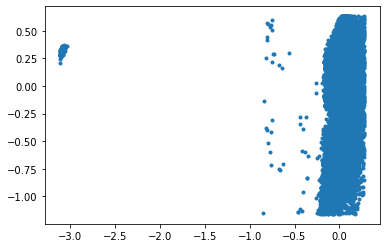

In [ ]:
hhh = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1])
q_low = hhh.quantile(0.03)
q_hi  = hhh.quantile(0.95)
df_filtered = hhh[(hhh < q_hi) & (hhh > q_low)]
print(df_filtered.shape)

hhh_2 = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==1,2])
q_low_2 = hhh_2.quantile(0.03)
q_hi_2  = hhh_2.quantile(0.95)
df_filtered_2 = hhh_2[(hhh_2 < q_hi_2) & (hhh_2 > q_low_2)]
print(df_filtered_2.shape)

plt.plot(df_filtered.iloc[:,0], df_filtered_2.iloc[:,0], '.')

In [ ]:

'''
from sklearn.preprocessing import KBinsDiscretizer
# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)
 c'est qui est bien avec KBinsDiscretizer est qu'il s'adapte aux éventuelles partitions au
sein d'une variable. En d'autres termes, si la méthode n'arrive pas à partitionner les individus
en k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, 
jusqu'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement 
une modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer 
l'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.


method_discre = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile') 
method_discre.fit(data.iloc[:,1:23])
resultat_discre = method_discre.transform(data.iloc[:,1:23])
resultat_discre

# construction du data frame après discrétisation
data2_index = data.iloc[:,0]
df_resultat_discre = pd.DataFrame(resultat_discre,columns=colonnes[1:23], dtype=int )
data_final = pd.concat([data2_index, df_resultat_discre,data["IFI+"]], axis=1 ) #data2_index
data_final

#nombre_mod(data_final)
#nombre_mod(data)

# description des modalités d'une variable
for k in range(1,data_final.shape[1]):
    print(data_final.iloc[:,k].value_counts(dropna=True)); print("="*50)

# description des modalités d'une variable
for k in range(1,data.shape[1]):
    print(data.iloc[:,k].value_counts(dropna=True)); print("="*50)

'''


In [ ]:
###########################################################################################################
#  PIPELINE

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
disqual =  Pipeline([("acm", MCA(var_labels = data.columns[1:num_var_max], )),("adl", LinearDiscriminantAnalysis())])

In [ ]:
disqual.fit(data.iloc[:127115, 1:-1].values, data.iloc[:127115, num_var_max] )



In [ ]:
#accès à l'ACM, nombre de composants
print(disqual.named_steps["acm"].n_components_)


In [ ]:
#afficher les valeurs propres
disqual.named_steps["acm"].plot_eigenvalues()


In [ ]:
#coefs. de la fonction score
print(disqual.named_steps["adl"].coef_)


In [ ]:
#prediction
pVote = disqual.predict(vote_test.iloc[:,:-1].values)
print(numpy.unique(pVote,return_counts=True))


In [ ]:
#nombres de facteurs à tester
parametres = [{"acm__n_components":[1,2,5,10,15,20,25,30,32]}]

In [ ]:
1771/4964

0.35676873489121674